In [ ]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import random as rand
from tqdm import tqdm
import random as rand

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

import sys
import os

# Agregar la carpeta 'src' al sys.path
src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.append(src_path)
    import support_DecisionTreeRegressor as sp

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/df_te.csv")
df.sample(5)

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,fuelType,brand,notRepairedDamage,powerCV_robust,kilometer_robust
18812,5722.744529,5722.69042,1400.0,5721.515220,5212.719911,1769.244434,4654.329823,4702.257069,8037.616582,6707.871077,0.043478,0.0
119308,5722.744529,5722.69042,16800.0,5721.515220,9342.620539,5236.859483,4654.329823,4702.257069,8229.975718,6707.871077,2.739130,0.0
239172,5722.744529,5722.69042,11000.0,5723.869135,9342.620539,11654.559866,9965.928441,8454.021359,8769.608410,6707.871077,0.797101,-5.8
137840,5722.744529,5722.69042,2499.0,5723.869135,5845.597432,1769.244434,4654.329823,4702.257069,5407.374502,6707.871077,1.434783,0.0
73138,5722.744529,5722.69042,3999.0,5723.869135,2912.480757,5236.859483,4654.329823,4702.257069,5407.374502,6707.871077,-0.405797,0.0


In [3]:
x=df.drop("price",axis=1)
y=df[["price"]]

In [4]:
x_train, x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)

In [41]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [50, 100, 150],
    'max_leaf_nodes': [30, 40, 50, 60, 70, 100]
}
grid_search_arbol=GridSearchCV(DecisionTreeRegressor(),
                               param_grid=params_arbol,
                               cv=5,
                               scoring="neg_mean_squared_error",
                               n_jobs=-1)

grid_search_arbol.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_leaf_nodes': [30, 40, 50, 60, 70, 100],
                         'min_samples_leaf': [50, 100, 150],
                         'min_samples_split': [10, 20]},
             scoring='neg_mean_squared_error')

In [42]:
modelo_arbol_final=grid_search_arbol.best_estimator_

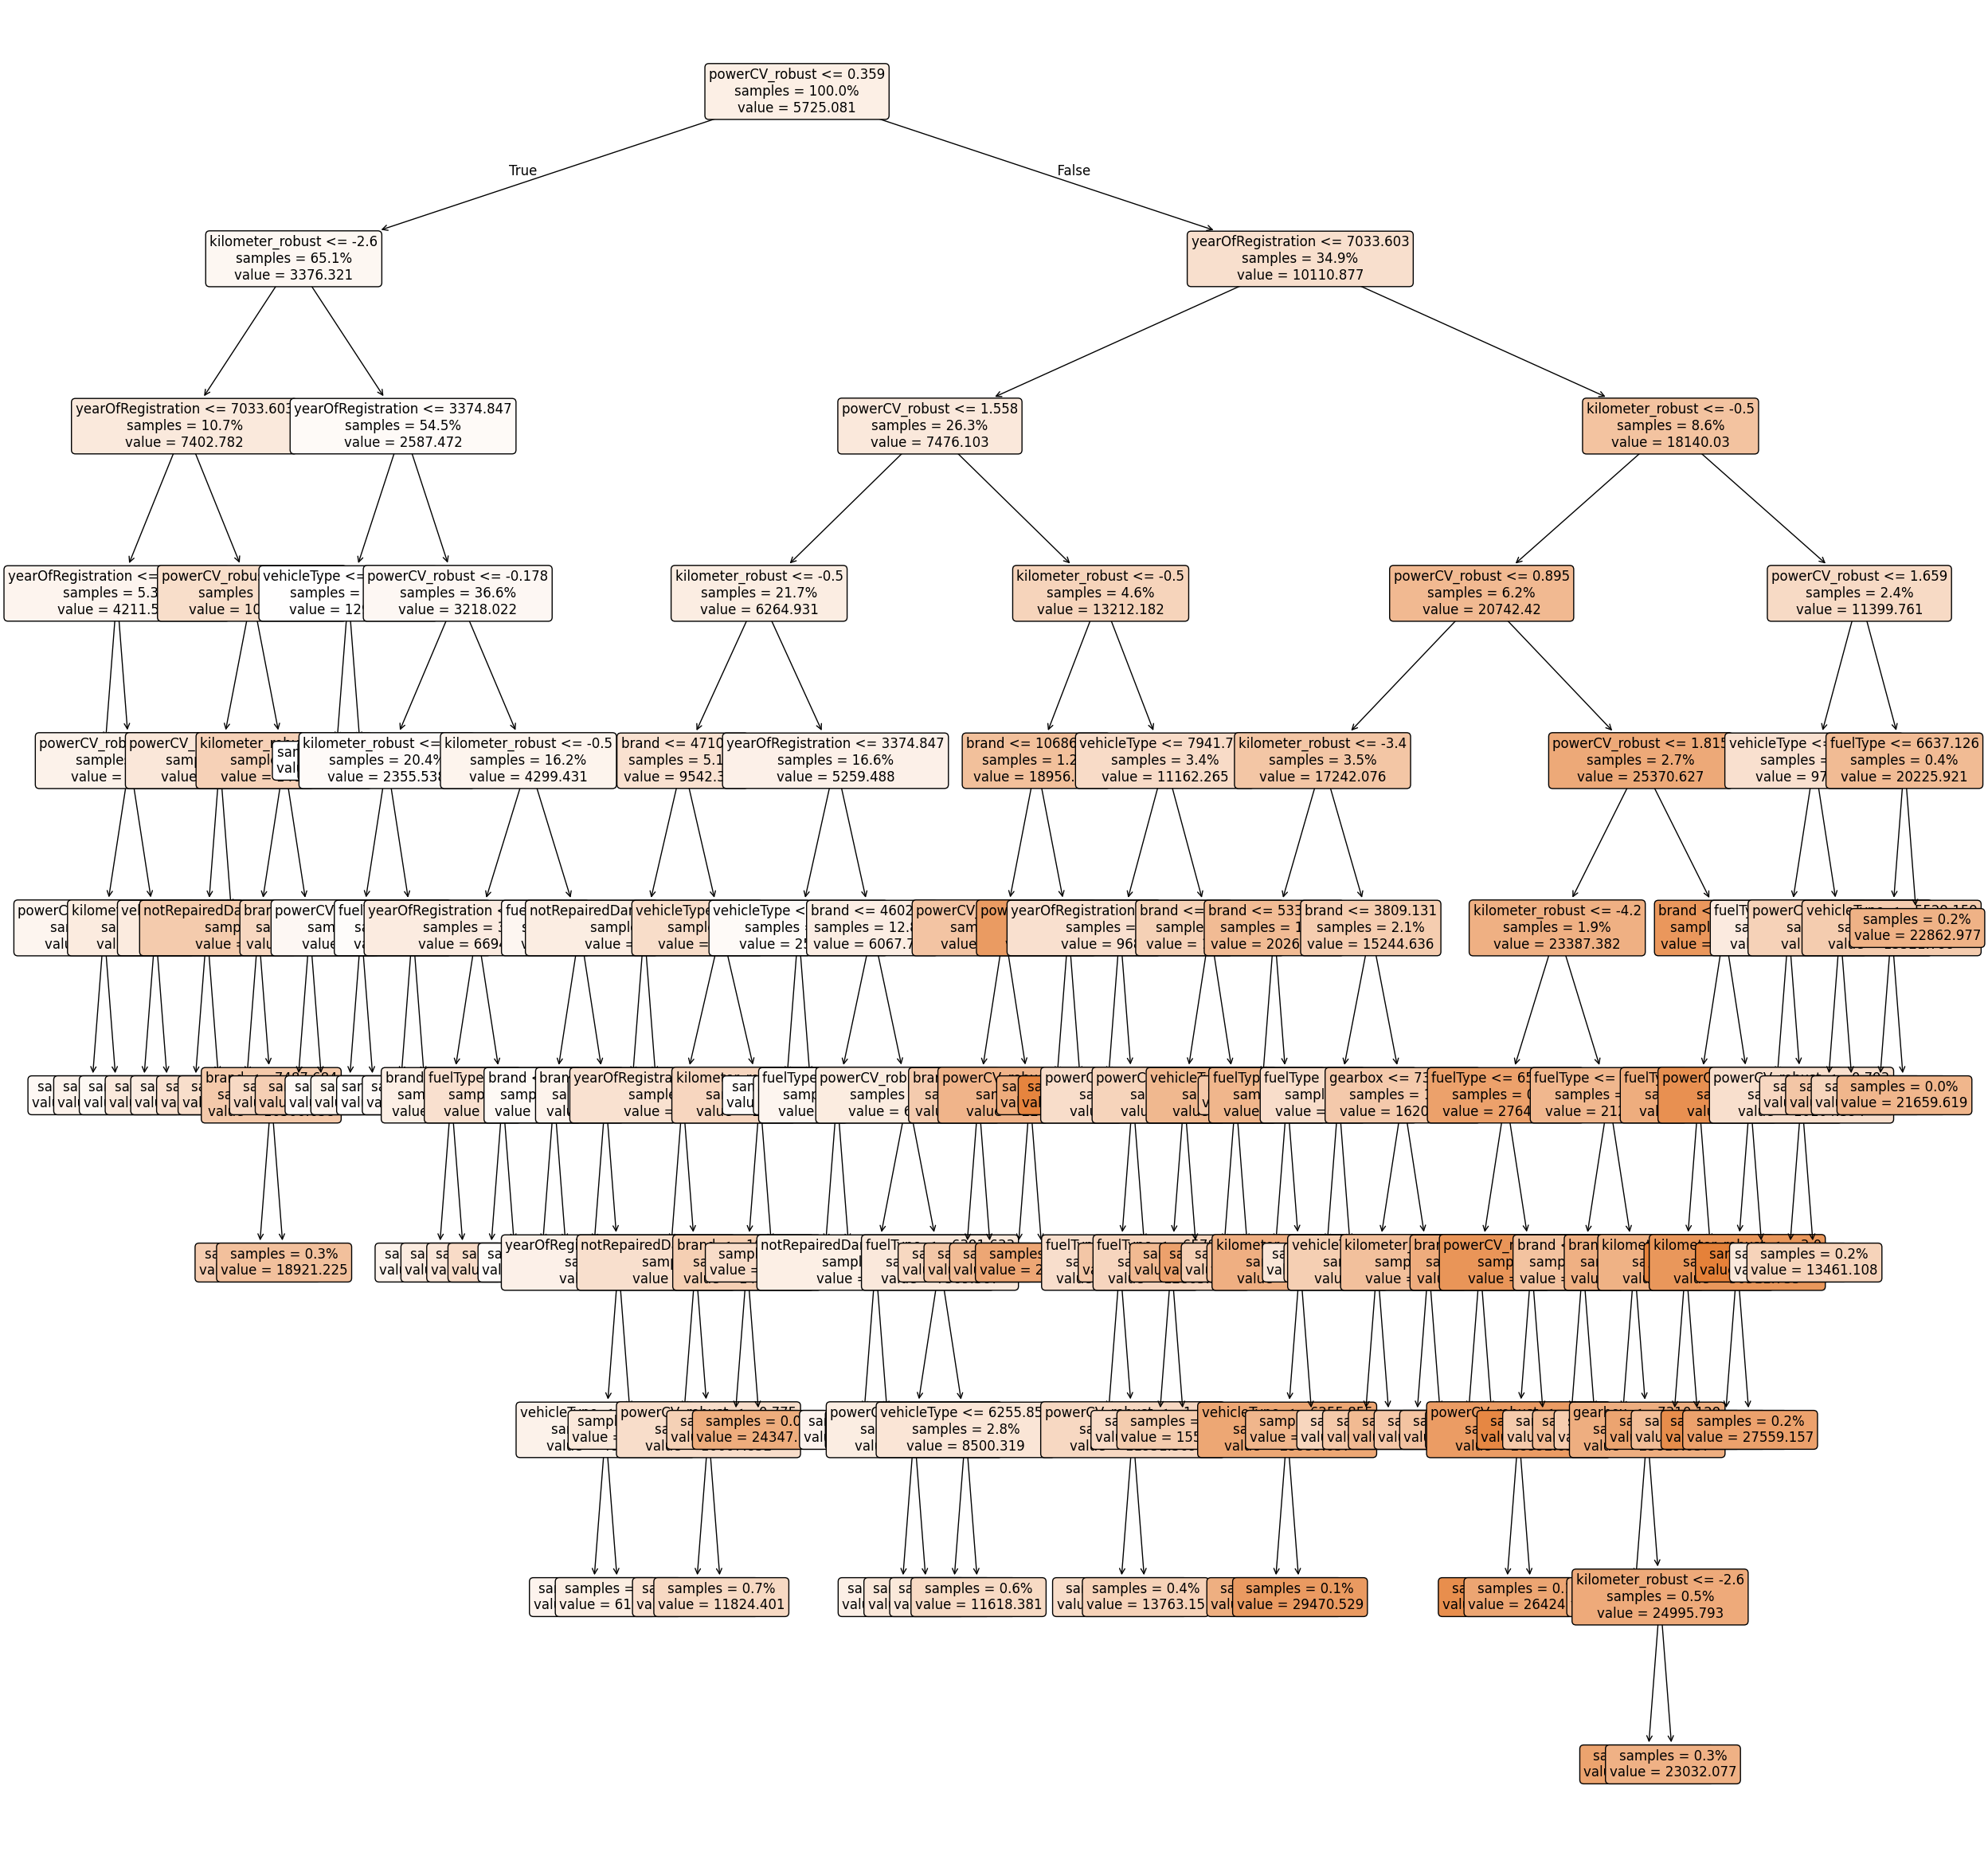

In [44]:
sp.graficar_arbol_decision(modelo_arbol_final,x.columns)

In [45]:
df_resultados_arbol=pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by="rank_test_score",ascending=True)
df_resultados_arbol_filtrado=df_resultados_arbol.filter(like="param").drop(columns="params")
df_resultados_arbol_filtrado["MSE"]=df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
102,20,100,50,10,-1.177297e+07
103,20,100,50,20,-1.177297e+07
66,10,100,50,10,-1.177297e+07
67,10,100,50,20,-1.177297e+07
68,10,100,100,10,-1.177817e+07
...,...,...,...,...,...
1,5,30,50,20,-1.491203e+07
5,5,30,150,20,-1.491203e+07
4,5,30,150,10,-1.491203e+07
3,5,30,100,20,-1.491203e+07


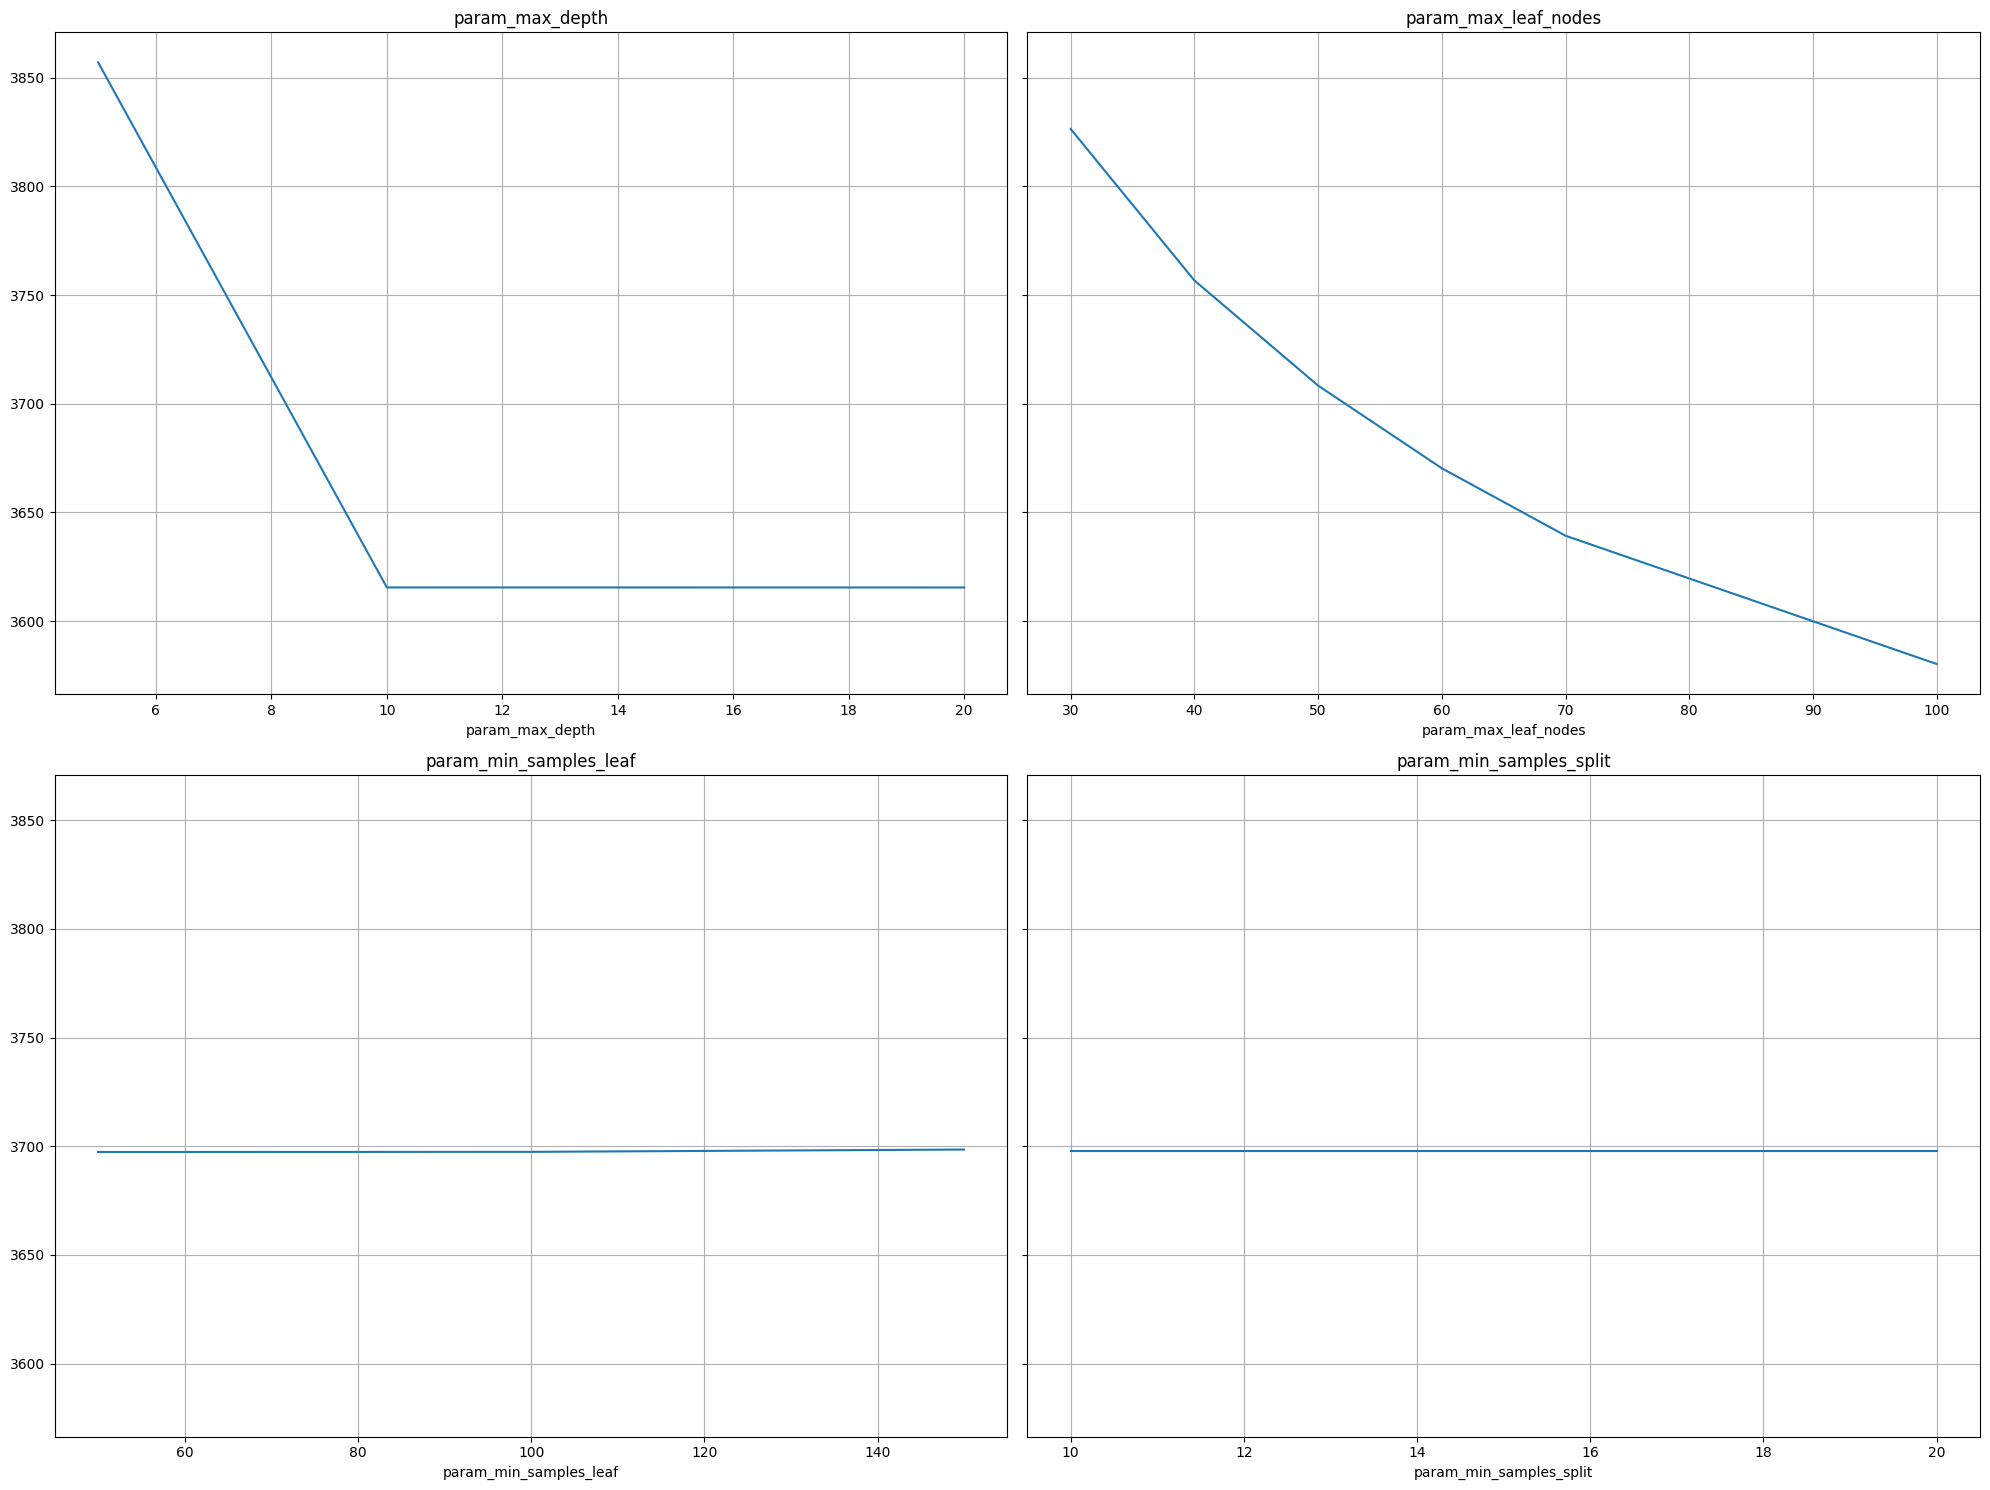

In [46]:
# Cálculo inicial del RMSE por 'param_max_depth'
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

# Configuración de la figura
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

# Iterar sobre columnas seleccionadas (excepto la última)
for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
# Asegurarse de no exceder el número de subgráficos
    if indice >= len(axes):
        break
    
    # Calcular RMSE agrupado por la columna actual
    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
    
    # Graficar
    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [51]:
# Excluir columnas irrelevantes según el análisis previo
columns_to_exclude = ['seller', 'offerType', 'abtest']
df_filtered = df.drop(columns=columns_to_exclude)

In [52]:
# Definir las características (X) y la variable objetivo (y)
x2 = df_filtered.drop(columns=['price'])
y2 = df_filtered['price']

In [59]:

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

# Inicializar y entrenar un modelo DecisionTreeRegressor con hiperparámetros optimizados
model = DecisionTreeRegressor(
    max_depth=10,          # Limitar la profundidad del árbol para evitar sobreajuste
    min_samples_split=50,  # Número mínimo de muestras para dividir un nodo
    min_samples_leaf=10,   # Número mínimo de muestras en una hoja
    random_state=42        # Asegurar reproducibilidad
)
model.fit(x_train2, y_train)

# Predecir en los datos de prueba
y_pred_test2 = model.predict(x_test2)
y_pred_train2 = model.predict(x_train2)

In [60]:
sp.metricas(y_train2, y_pred_train2, y_test2, y_pred_test2)

,r2_score,MAE,MSE,RMSE
train,0.795733,1817.608104,9.229306e+06,3037.977243
test,0.778686,1859.878889,9.845895e+06,3137.816955
diferences,0.017046,-42.270785,-6.165895e+05,-99.839712


In [ ]:
# Definir el grid de parámetros
params_arbol = {
    'max_depth': [5, 10, 15, 20, 30, None],  # Explorar profundidad fija y sin límite
    'min_samples_split': [2, 10, 20, 50, 100],  # Divisiones con más o menos datos
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],  # Nodos hoja con diferentes tamaños mínimos
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200],  # Limitar o no el número de nodos hoja
}

# Configurar GridSearchCV
grid_search_arbol2 = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=params_arbol,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Entrenar el modelo con GridSearchCV
grid_search_arbol2.fit(x_train2, y_train2)

# Mostrar los mejores parámetros y el error asociado
best_params = grid_search_arbol2.best_params_

print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Mejor MSE (validación): 7942256.112256457


In [67]:
grid_search_arbol2

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 30, None],
                         'max_leaf_nodes': [None, 20, 30, 50, 100, 200],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'min_samples_split': [2, 10, 20, 50, 100]},
             scoring='neg_mean_squared_error')

In [64]:
y_pred_test3 = grid_search_arbol2.predict(x_test2)
y_pred_train3 = grid_search_arbol2.predict(x_train2)
sp.metricas(y_train2, y_pred_train3, y_test2, y_pred_test3)

,r2_score,MAE,MSE,RMSE
train,0.875047,1361.569728,5.645678e+06,2376.063655
test,0.822728,1564.848724,7.886547e+06,2808.299673
diferences,0.052319,-203.278996,-2.240869e+06,-432.236018


In [66]:
df_resultados_arbol2=pd.DataFrame(grid_search_arbol2.cv_results_).sort_values(by="rank_test_score",ascending=True)
df_resultados_arbol_filtrado2=df_resultados_arbol2.filter(like="param").drop(columns="params")
df_resultados_arbol_filtrado2["MSE"]=df_resultados_arbol2["mean_test_score"]
df_resultados_arbol_filtrado2

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
547,20,None,5,20,-7.942256e+06
727,30,None,5,20,-7.943686e+06
907,None,None,5,20,-7.943732e+06
546,20,None,5,10,-8.007548e+06
545,20,None,5,2,-8.007548e+06
...,...,...,...,...,...
595,20,20,100,2,-1.573798e+07
596,20,20,100,10,-1.573798e+07
597,20,20,100,20,-1.573798e+07
598,20,20,100,50,-1.573798e+07


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Definir el grid de hiperparámetros para reducir sobreajuste
param_grid = {
    'max_depth': [5, 10, 15, 20],  # Limitar la profundidad del árbol
    'min_samples_split': [10, 20, 50],  # Aumentar muestras mínimas para dividir un nodo
    'min_samples_leaf': [5, 10, 20],  # Aumentar muestras mínimas en nodos hoja
}

# Configurar el modelo y la búsqueda
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Validación cruzada
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Entrenar el modelo
grid_search.fit(x_train2, y_train2)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en entrenamiento y prueba
y_train_pred4 = best_model.predict(x_train2)
y_test_pred4 = best_model.predict(x_test2)

# Calcular métricas
metrics = {
    "r2_score_train": r2_score(y_train2, y_train_pred4),
    "r2_score_test": r2_score(y_test2, y_test_pred4),
    "MAE_train": mean_absolute_error(y_train2, y_train_pred4),
    "MAE_test": mean_absolute_error(y_test2, y_test_pred4),
    "MSE_train": mean_squared_error(y_train2, y_train_pred4),
    "MSE_test": mean_squared_error(y_test2, y_test_pred4),
    "RMSE_train": np.sqrt(mean_squared_error(y_train2, y_train_pred4)),
    "RMSE_test": np.sqrt(mean_squared_error(y_test2, y_test_pred4)),
}

# Mostrar resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Métricas del modelo:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
Métricas del modelo:
r2_score_train: 0.8750
r2_score_test: 0.8227
MAE_train: 1361.5697
MAE_test: 1564.8487
MSE_train: 5645678.4912
MSE_test: 7886547.0523
RMSE_train: 2376.0637
RMSE_test: 2808.2997


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Grid de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100],  # Número de árboles
    'max_depth': [10, 15, 20],  # Limitar profundidad
    'min_samples_split': [10, 20, 50],  # Fragmentación mínima
    'min_samples_leaf': [5, 10, 20],  # Muestras mínimas por nodo hoja
}

# Configuración y entrenamiento del modelo
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(x_train2, y_train2)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_

# Predicciones
y_train_pred_rf = best_rf.predict(x_train2)
y_test_pred_rf = best_rf.predict(x_test2)

# Métricas
metrics_rf = {
    "r2_score_train": r2_score(y_train2, y_train_pred_rf),
    "r2_score_test": r2_score(y_test2, y_test_pred_rf),
    "MAE_train": mean_absolute_error(y_train2, y_train_pred_rf),
    "MAE_test": mean_absolute_error(y_test2, y_test_pred_rf),
    "MSE_train": mean_squared_error(y_train2, y_train_pred_rf),
    "MSE_test": mean_squared_error(y_test2, y_test_pred_rf),
    "RMSE_train": np.sqrt(mean_squared_error(y_train2, y_train_pred_rf)),
    "RMSE_test": np.sqrt(mean_squared_error(y_test2, y_test_pred_rf)),
}

# Resultados
print("Mejores hiperparámetros RF:", grid_search_rf.best_params_)
print("Métricas del modelo RF:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")
